In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.utils.vis_utils import plot_model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

#import keras.backend.tensorflow_backend as kk

from tensorflow.compat.v1 import ConfigProto, InteractiveSession
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
print(os.listdir('/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013'))

['test', 'train']


In [ ]:
train_dir ='/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/train'
test_dir  ='/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/test'

In [ ]:
print('Count of Images in Training Set: ')
for exp in os.listdir(train_dir):
    print(str(len(os.listdir(train_dir+'/'+exp)))+" "+exp+" "+"images")

Count of Images in Training Set: 
436 disgust images
3995 angry images
4097 fear images
4830 sad images
4965 neutral images
7215 happy images
3171 surprise images


In [ ]:
print('Count of Images in Testing Set: ')
for exp in os.listdir(test_dir):
    print(str(len(os.listdir(test_dir+'/'+exp)))+" "+exp +" "+"images")

Count of Images in Testing Set: 
831 surprise images
1024 fear images
958 angry images
1247 sad images
1774 happy images
111 disgust images
1233 neutral images



Preprocessing
---



In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)                    
training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Modeling

In [ ]:
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), " Physical GPUs, ", len(logical_gpus), " Logical GPUs")

        except RuntimeError as e:
            print(e)

    """
    kk.clear_session()
    config = ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.8
    session = InteractiveSession(config=config)
    """

    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module5 - add layer
    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(256, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module6 - add layer
    residual = Conv2D(512, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(512, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(512, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['poisson','accuracy'])
    return model

In [ ]:
fernet = mini_XCEPTION((48,48,1),7,0.01)
fernet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 8)    72          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 46, 46, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['batch_normalization[0][0]']

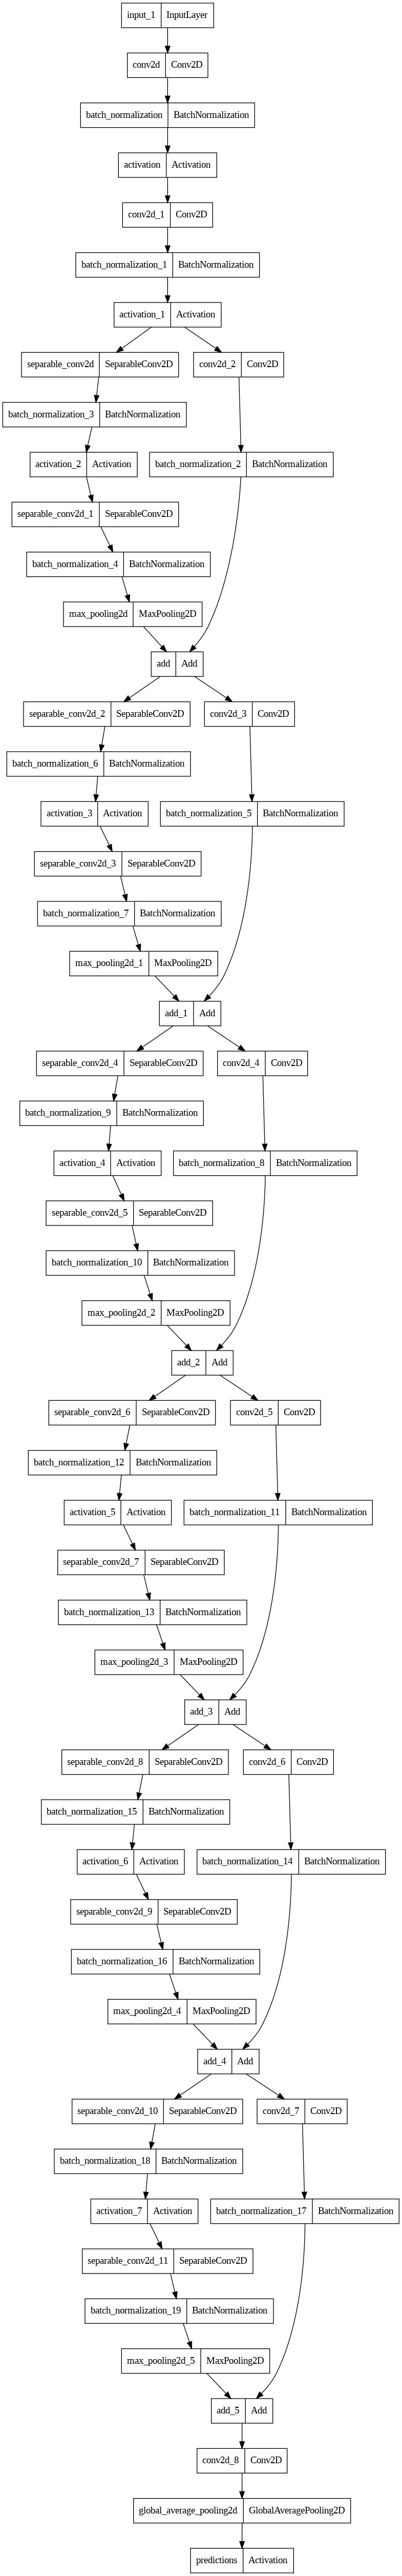

In [ ]:
plot_model(fernet, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
chk_path = 'ferNet.h5'
log_dir = "/content/gdrive/MyDrive/checkpoints/logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

In [ ]:
hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=50,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 0.4217 - poisson: 0.3898 - accuracy: 0.3353 
Epoch 1: val_loss improved from inf to 0.44304, saving model to ferNet.h5
448/448 [==============================] - 6178s 14s/step - loss: 0.4217 - poisson: 0.3898 - accuracy: 0.3353 - val_loss: 0.4430 - val_poisson: 0.3989 - val_accuracy: 0.2868 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 0.3483 - poisson: 0.3637 - accuracy: 0.4170
Epoch 2: val_loss improved from 0.44304 to 0.32755, saving model to ferNet.h5
448/448 [==============================] - 358s 799ms/step - loss: 0.3483 - poisson: 0.3637 - accuracy: 0.4170 - val_loss: 0.3276 - val_poisson: 0.3538 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 0.3200 - poisson: 0.3485 - accuracy: 0.4679
Epoch 3: val_loss did not improve from 0.32755
448/448 [==============================] - 362s 808ms/step - loss: 0.3200 - poisson

Result

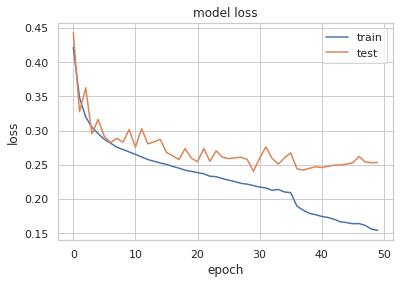

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

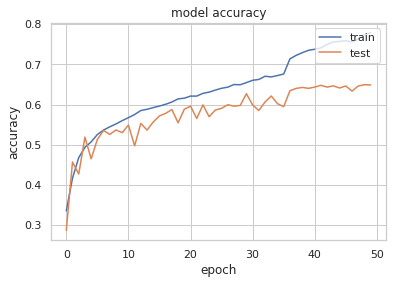

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

Music recommendation

In [ ]:
music_df =pd.read_csv('/content/gdrive/MyDrive/솔룩스 인텔리송/music_mood_data.csv')

In [ ]:
music_df.head()

,name,artist,mood
0,Ditto,NewJeans,neutral
1,OMG,NewJeans,neutral
2,Hype boy,NewJeans,neutral
3,사건의 지평선,윤하 (YOUNHA),neutral
4,VIBE (feat. Jimin of BTS),태양,neutral


In [ ]:
music_df["mood"].value_counts()

energetic    147
calm         104
neutral      100
sad          100
Name: mood, dtype: int64

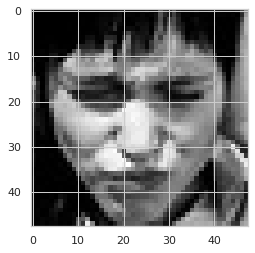

In [ ]:
# sad -> sad
image = cv2.imread('/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/test/sad/PrivateTest_10455506.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 21ms/step


3

In [ ]:
# Making Songs Recommendations Based on Predicted Class
if( result[0]==5 ): # sad

        Play = music_df[music_df['mood'] =='sad' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==3 or result[0]==1): # happy & disgust

        Play = music_df[music_df['mood'] =='energetic' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==2 or result[0]==0 or result[0]==6 ): # fear & angry & surprise
        
        Play = music_df[music_df['mood'] =='calm' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)
        
if( result[0]==4): # neutral

        Play = music_df[music_df['mood'] =='neutral' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

,name,artist,mood
0,FINGERTIP,여자친구 (GFRIEND),energetic
1,SHUT DOWN,CLASS:y (클라씨),energetic
2,IDOL,방탄소년단,energetic
3,YEPPI YEPPI,aespa,energetic
4,FINGERTIP,여자친구 (GFRIEND),energetic


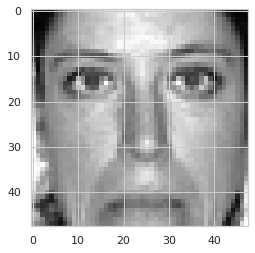

In [ ]:
# disgust -> energetic
image = cv2.imread('/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/test/disgust/PrivateTest_11895083.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 21ms/step


0

In [ ]:
# Making Songs Recommendations Based on Predicted Class
if( result[0]==5 ): # sad

        Play = music_df[music_df['mood'] =='sad' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==3 or result[0]==1): # happy & disgust

        Play = music_df[music_df['mood'] =='energetic' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==2 or result[0]==0 or result[0]==6 ): # fear & angry & surprise
        
        Play = music_df[music_df['mood'] =='calm' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)
        
if( result[0]==4): # neutral

        Play = music_df[music_df['mood'] =='neutral' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

,name,artist,mood
0,Borodin : Petite Suite No.2 - Mazurka Allegret...,상쾌한 클래식,calm
1,"Ave Maria, Op.52,No.6, D.839",The Hungarian Radio Choir,calm
2,Albeniz : Suite Espanola No.1 Op.47 - V. Astur...,Matsuda Gen,calm
3,Brahms : Piano Sonata No.1 In C Major Op.1 - I...,상쾌한 클래식,calm
4,Beethoven : Piano Sonata No.14 In C Sharp Mino...,편안한 클래식,calm


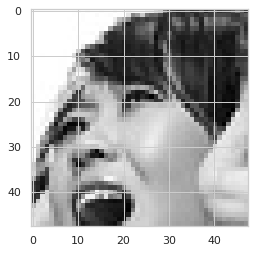

In [ ]:
# fear -> calm .
image = cv2.imread('/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/test/fear/PrivateTest_10153550.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 103ms/step


5

In [ ]:
# Making Songs Recommendations Based on Predicted Class
if( result[0]==5 ): # sad

        Play = music_df[music_df['mood'] =='sad' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==3 or result[0]==1): # happy & disgust

        Play = music_df[music_df['mood'] =='energetic' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==2 or result[0]==0 or result[0]==6 ): # fear & angry & surprise
        
        Play = music_df[music_df['mood'] =='calm' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)
        
if( result[0]==4): # neutral

        Play = music_df[music_df['mood'] =='neutral' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

,name,artist,mood
0,홀로 (Feat. 김나영),정키,sad
1,추억은 만남보다 이별에 남아,정동하,sad
2,늦은 밤 너의 집 앞 골목길에서,노을,sad
3,이름에게,아이유,sad
4,어떻게 지내 (Prod. By VAN.C),오반,sad


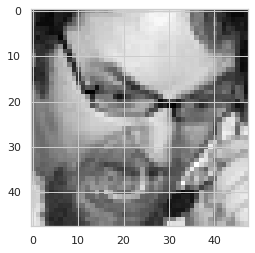

In [ ]:
# angry -> calm .
image = cv2.imread('/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/test/angry/PrivateTest_10131363.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 21ms/step


2

In [ ]:
# Making Songs Recommendations Based on Predicted Class
if( result[0]==5 ): # sad

        Play = music_df[music_df['mood'] =='sad' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==3 or result[0]==1): # happy & disgust

        Play = music_df[music_df['mood'] =='energetic' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==2 or result[0]==0 or result[0]==6 ): # fear & angry & surprise
        
        Play = music_df[music_df['mood'] =='calm' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)
        
if( result[0]==4): # neutral

        Play = music_df[music_df['mood'] =='neutral' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

,name,artist,mood
0,Schumann : Scenes From Childhood Op.15 - XIII....,잔잔한 피아노,calm
1,Grieg : Lyric Pieces Book I. Op.12 - IV. Fairy...,피아노클래식,calm
2,Debussy : Suite Bergamasque L.75 - II. Menuet ...,상쾌한 클래식,calm
3,Albeniz : Suite Espanola No.1 Op.47 - IV. Cadi...,상쾌한 클래식,calm
4,Albeniz : Suite Espanola Op.47 - VII. Castilla...,편안한 클래식,calm


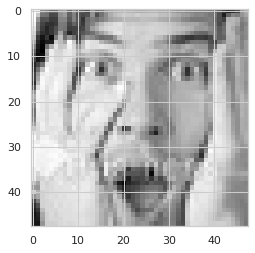

In [ ]:
# surprise -> calm
image = cv2.imread('/content/gdrive/MyDrive/솔룩스 인텔리송/fer2013/test/surprise/PrivateTest_10072988.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 32ms/step


0

In [ ]:
# Making Songs Recommendations Based on Predicted Class
if( result[0]==5 ): # sad

        Play = music_df[music_df['mood'] =='sad' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==3 or result[0]==1): # happy & disgust

        Play = music_df[music_df['mood'] =='energetic' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

if( result[0]==2 or result[0]==0 or result[0]==6 ): # fear & angry & surprise
        
        Play = music_df[music_df['mood'] =='calm' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)
        
if( result[0]==4): # neutral

        Play = music_df[music_df['mood'] =='neutral' ]
        Play = Play.sample(n=5)
        Play = Play.reset_index(drop=True)
        display(Play)

,name,artist,mood
0,Clementi : Piano Sonatine No.3 In C Major Op.3...,잔잔한 피아노,calm
1,Debussy : Suite Bergamasque L.75 - II. Menuet ...,상쾌한 클래식,calm
2,Burgmueller 18 Etudes Op.109 - The Pearls (부르크...,편안한 클래식,calm
3,MISS BRAND NEW DAY,Yumi Yamagata,calm
4,Mozart : Lullaby (모차르트 : 자장가),잠들기전,calm
